In [1]:
import os
import pygmt
import imageio
import xarray as xr
import numpy as np
import pygplates
from scripts import mapOutputs2D as mout

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

# Export to netcdf


> We first export the model outputs as netcdf files. We use `netcdf` files here as they offer more flexibilities and functionalities than `hdf5` ones for sharing and plotting.


![view](img/data.png)

We first define a folder where exported files will be stored:

In [2]:
# Define output folder name for the simulation
out_path = 'export/'

if not os.path.exists(out_path):
    os.makedirs(out_path)

Then we will be using the `mapOutputs` Python class to first extract the outputs, remap the unstructured variables on a structured mesh (the resolution of this mesh is defined by the `reso` parameter set in degree). The class is also performing additional calculations on the dataset to extract individual catchments based on flow accumulation and elevation.

The interpolated model's variables are then exported as `netCDF` files, and each of them contains the following:

+ elevation `elevation` (m)
+ cumulative erosion/deposition `erodep` (m)
+ water flux discharge (accounting for lakes) `fillDischarge`(m3/yr)
+ water flux in rivers (not showing lakes) `flowDischarge` (m3/yr)
+ sediment flux in rivers `sedimentLoad` (m3/yr)
+ main basin ids `basinID` (integer)
+ rainfall `precipitation` (m/yr)
+ tectonic `uplift` (m/yr)

In [7]:
stp = 0

# Name of each netcdf output file
ncout = os.path.join(out_path, "data")

# Initialisation of the class
grid = mout.mapOutputs(path='./', filename='snedden.yml', step=stp, uplift=False, model="utm")

We perform the export using the following loop:

In [8]:
for k in range(0,19):
    
    if stp>1:
        # Get goSPL variables
        grid.getData(stp)
        
    # Remap the variables on the regular mesh using distance weighting interpolation
    grid.buildUTMmesh(res=5000., nghb=3)
    
    # Export corresponding regular mesh variables as netCDF file
    grid.exportNetCDF(ncfile = ncout+str(k)+'Ma.nc')
    stp += 1

# Plotting some outputs

In [11]:
# We chose a time
step = 10

# and open the netCDF file
dataset = xr.open_dataset(out_path+'/data'+str(step)+'Ma.nc')
dataset

<xarray.Dataset>
Dimensions:        (y: 694, x: 1090)
Coordinates:
  * y              (y) float64 -2.561e-09 5e+03 1e+04 ... 3.46e+06 3.465e+06
  * x              (x) float64 0.0 5e+03 1e+04 ... 5.435e+06 5.44e+06 5.445e+06
Data variables:
    elevation      (y, x) float64 ...
    erodep         (y, x) float64 ...
    precipitation  (y, x) float64 ...
    fillDischarge  (y, x) float64 ...
    flowDischarge  (y, x) float64 ...
    sedimentLoad   (y, x) float64 ...
    basinID        (y, x) int32 ...
Attributes:
    description:  gospl outputs
    history:      Created Thu Nov 25 15:10:27 2021

### Elevation

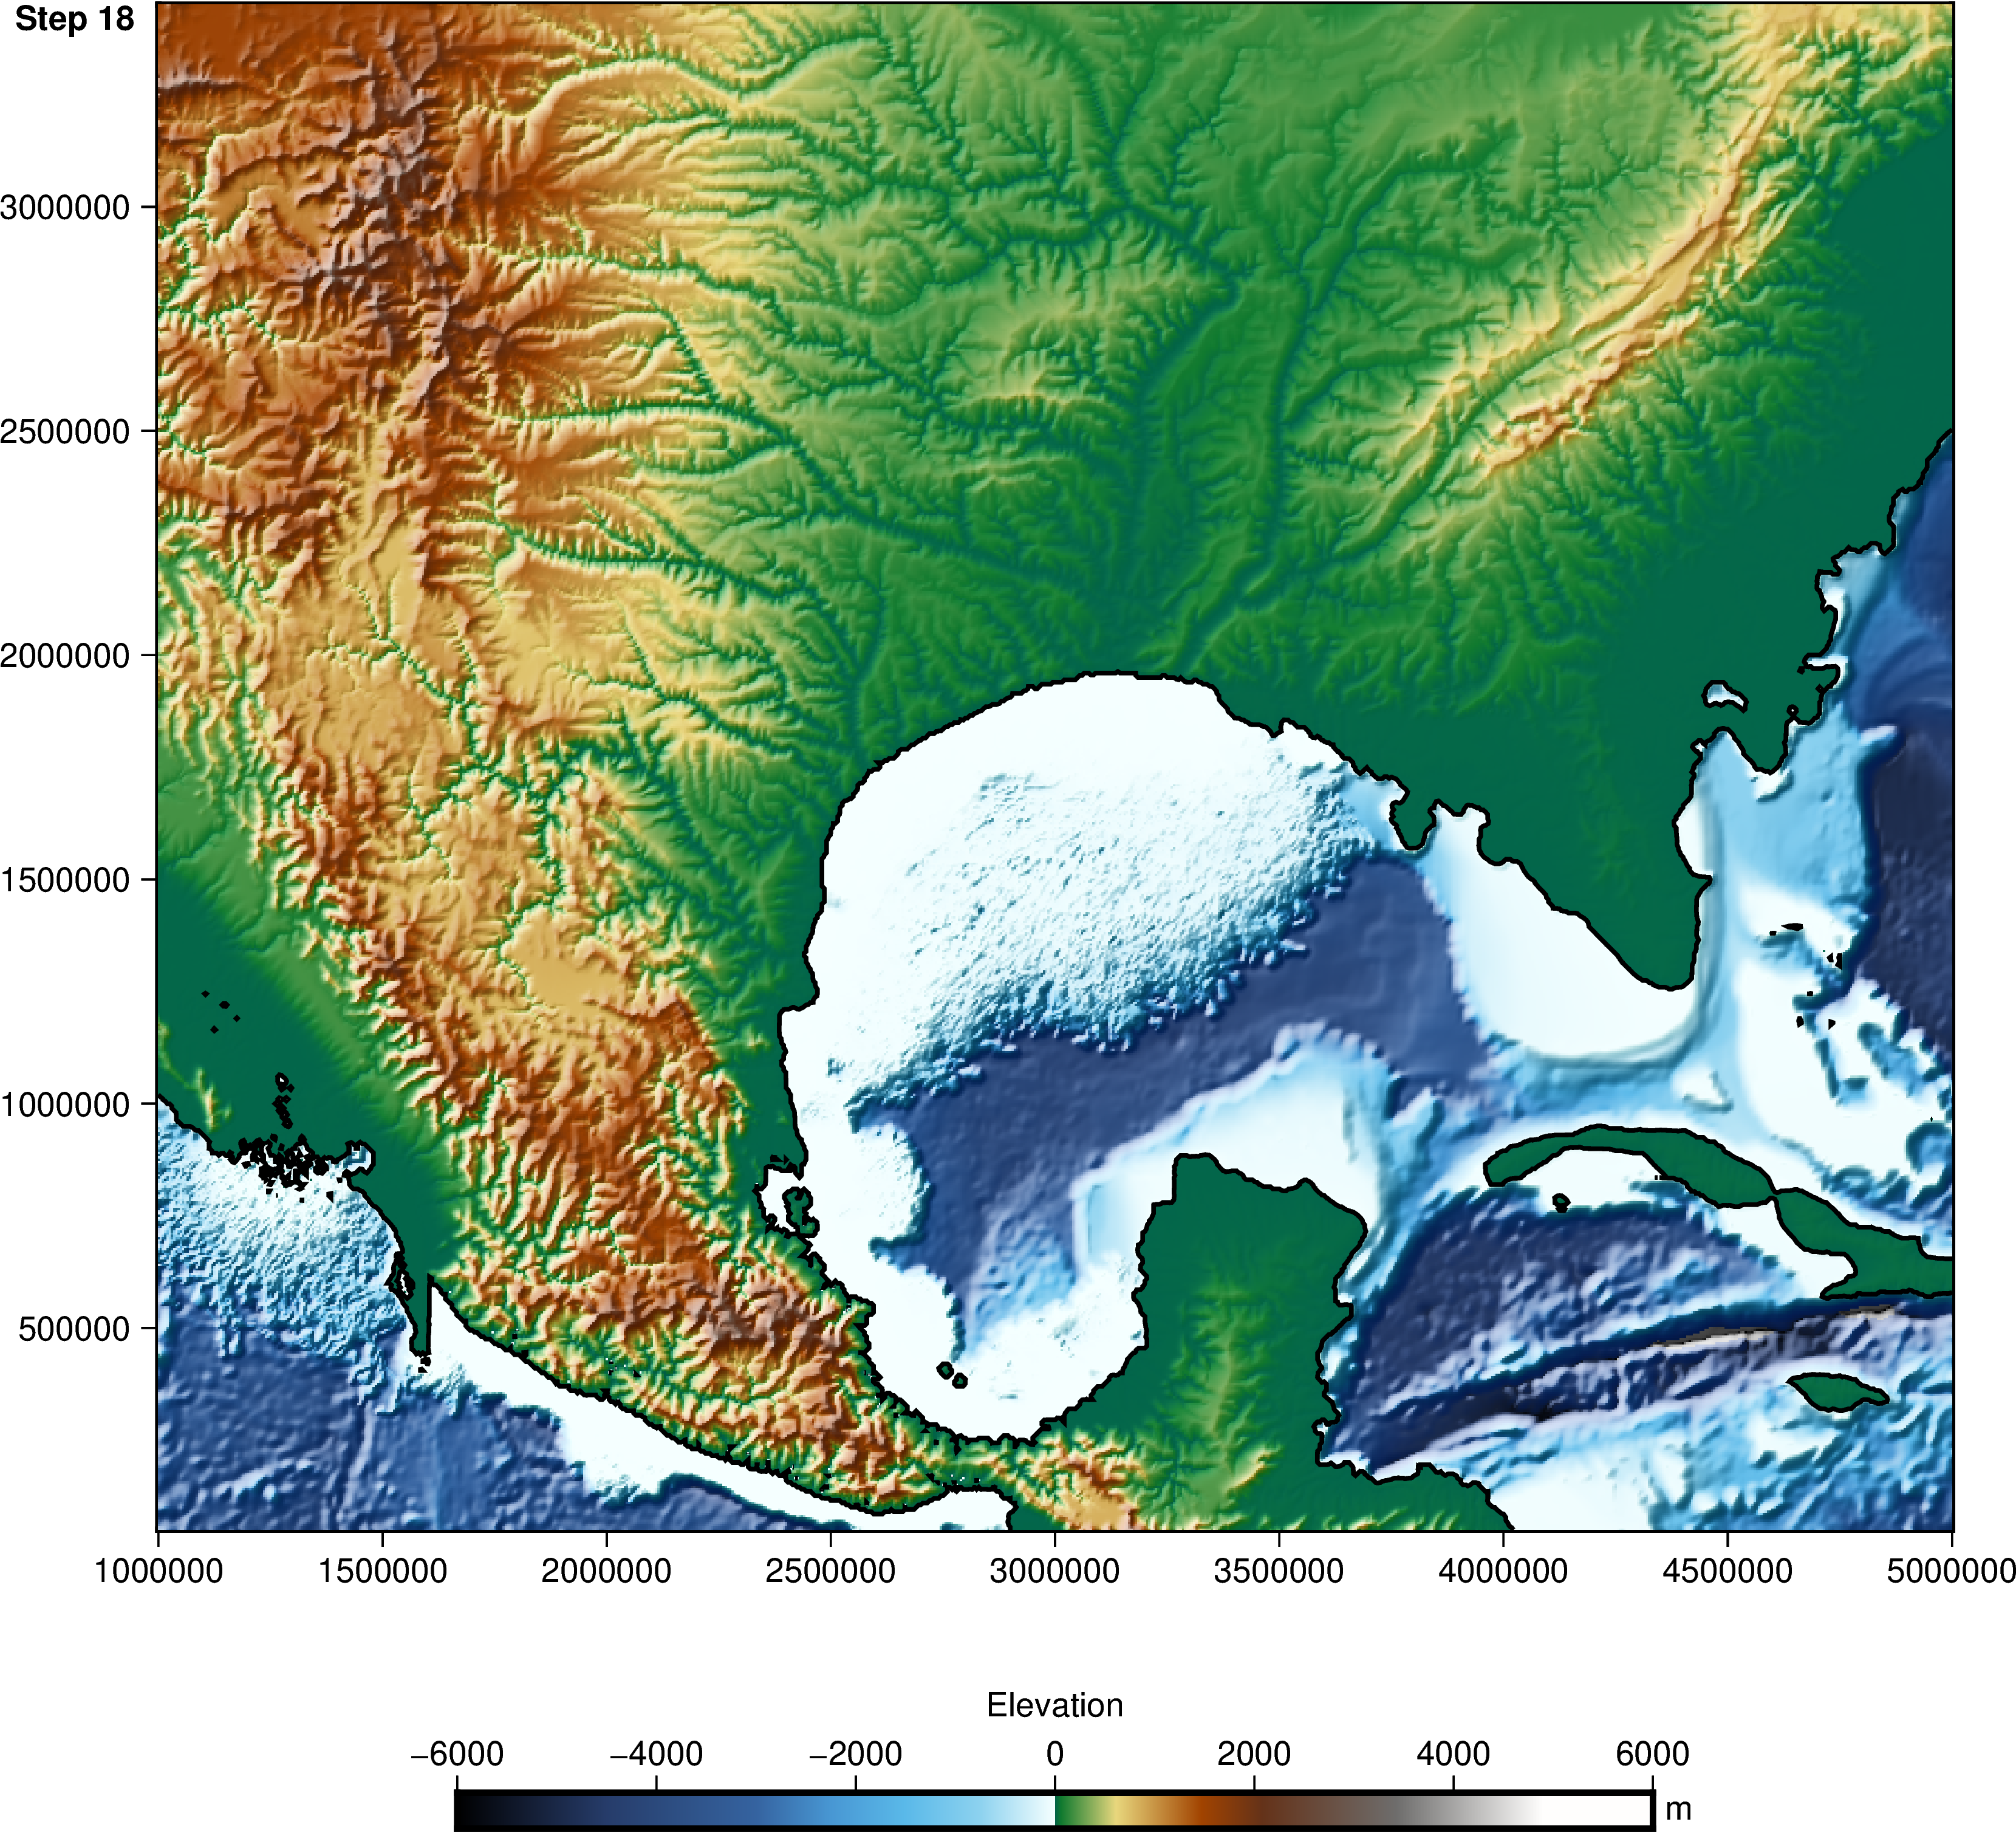

In [51]:
fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black'):
    pygmt.makecpt(cmap="geo", series=[-6000, 6000]) 
    
    fig.basemap(
        region=[1.e6,5.e6,5e4,3.45e6],
        frame=['a'],
        projection="X15c/12.75c",
    )
    fig.grdimage(dataset.elevation, shading=True, frame=False)
    fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
    fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")
    
    # Customising the font style
    fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
fig.show(dpi=500, width=500)

Let us save all the elevations for a specific simulation to make a movie as the one presented in the github repository

In [43]:
for step in range(19):
#     step = times[k]
    dataset = xr.open_dataset(out_path+'/data'+str(step)+'Ma.nc')

    fig = pygmt.Figure()
    with pygmt.config(FONT='8p,Helvetica,black'):
        pygmt.makecpt(cmap="geo", series=[-6000, 6000]) 

        fig.basemap(
            region=[1.e6,5.e6,5e4,3.45e6],
            frame=['a'],
            projection="X15c/12.75c",
        )
        fig.grdimage(dataset.elevation, shading=True, frame=False)
        fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
        fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")
    
        # Customising the font style
        fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
    fname = out_path+'/elev'+str(step)+'.png'
    fig.savefig(fname=fname,dpi=500)

We can now make a movie out of these figures

In [44]:
images = []
for step in range(19):
    filename = out_path+'/elev'+str(step)+'.png'
    images.append(imageio.imread(filename))
    
imageio.mimsave(out_path+'/elevation.mp4', images, fps=1)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (3319, 3017) to (3328, 3024) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x7fdec8808200] Stream #0: not enough frames to estimate rate; consider increasing probesize
[swscaler @ 0x7fdeb8018000] Warning: data is not aligned! This can lead to a speed loss


### Erosion/Deposition

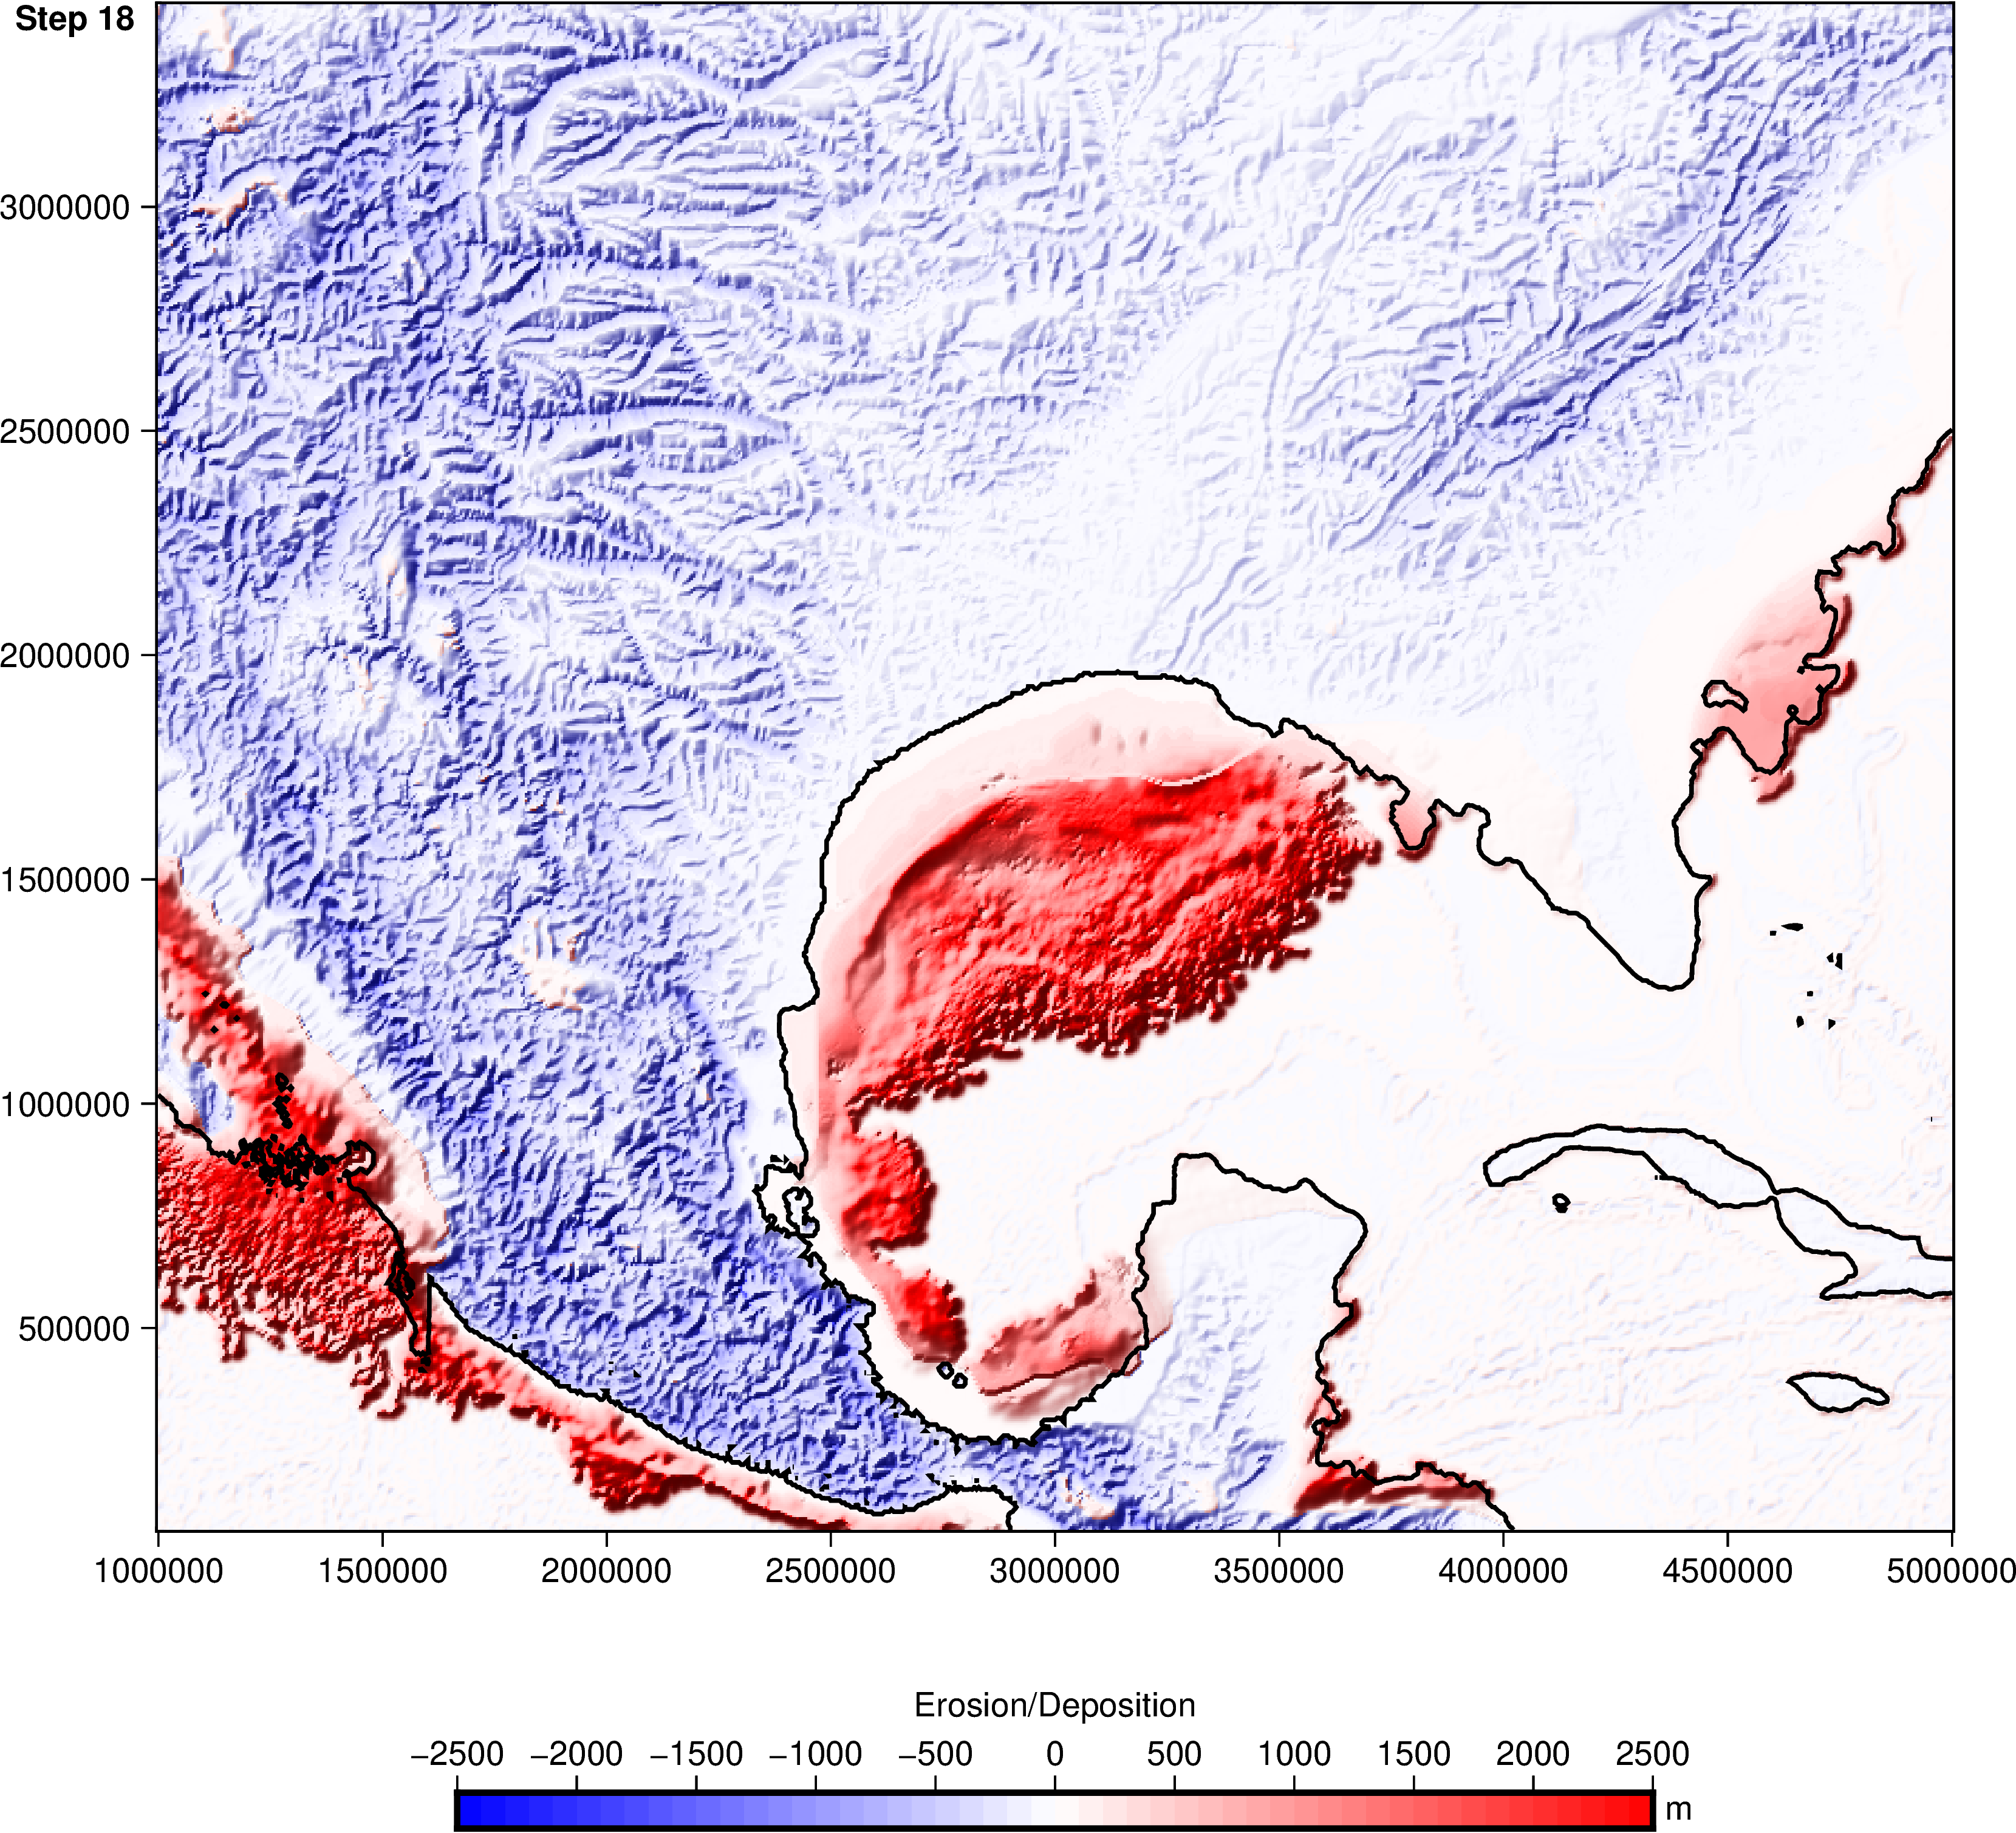

In [52]:
fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black',COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    pygmt.makecpt(cmap="polar", series=[-2500,2500, 100]) 
    
    fig.basemap(
        region=[1.e6,5.e6,5e4,3.45e6],
        frame=['a'],
        projection="X15c/12.75c",
    )
    fig.grdimage(dataset.erodep, shading=True, frame=False)
    fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
    fig.colorbar(frame=["a500", "x+lErosion/Deposition", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

    # Customising the font style
    fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")

fig.show(dpi=500, width=500)

### Discharge

In [48]:
# We will use a log scale here
vals = np.log10(dataset.fillDischarge)

# Let's look at the maximum log values (we will use it to set our colour bar in the figure below)
vals.max()

<xarray.DataArray 'fillDischarge' ()>
array(12.39989548)

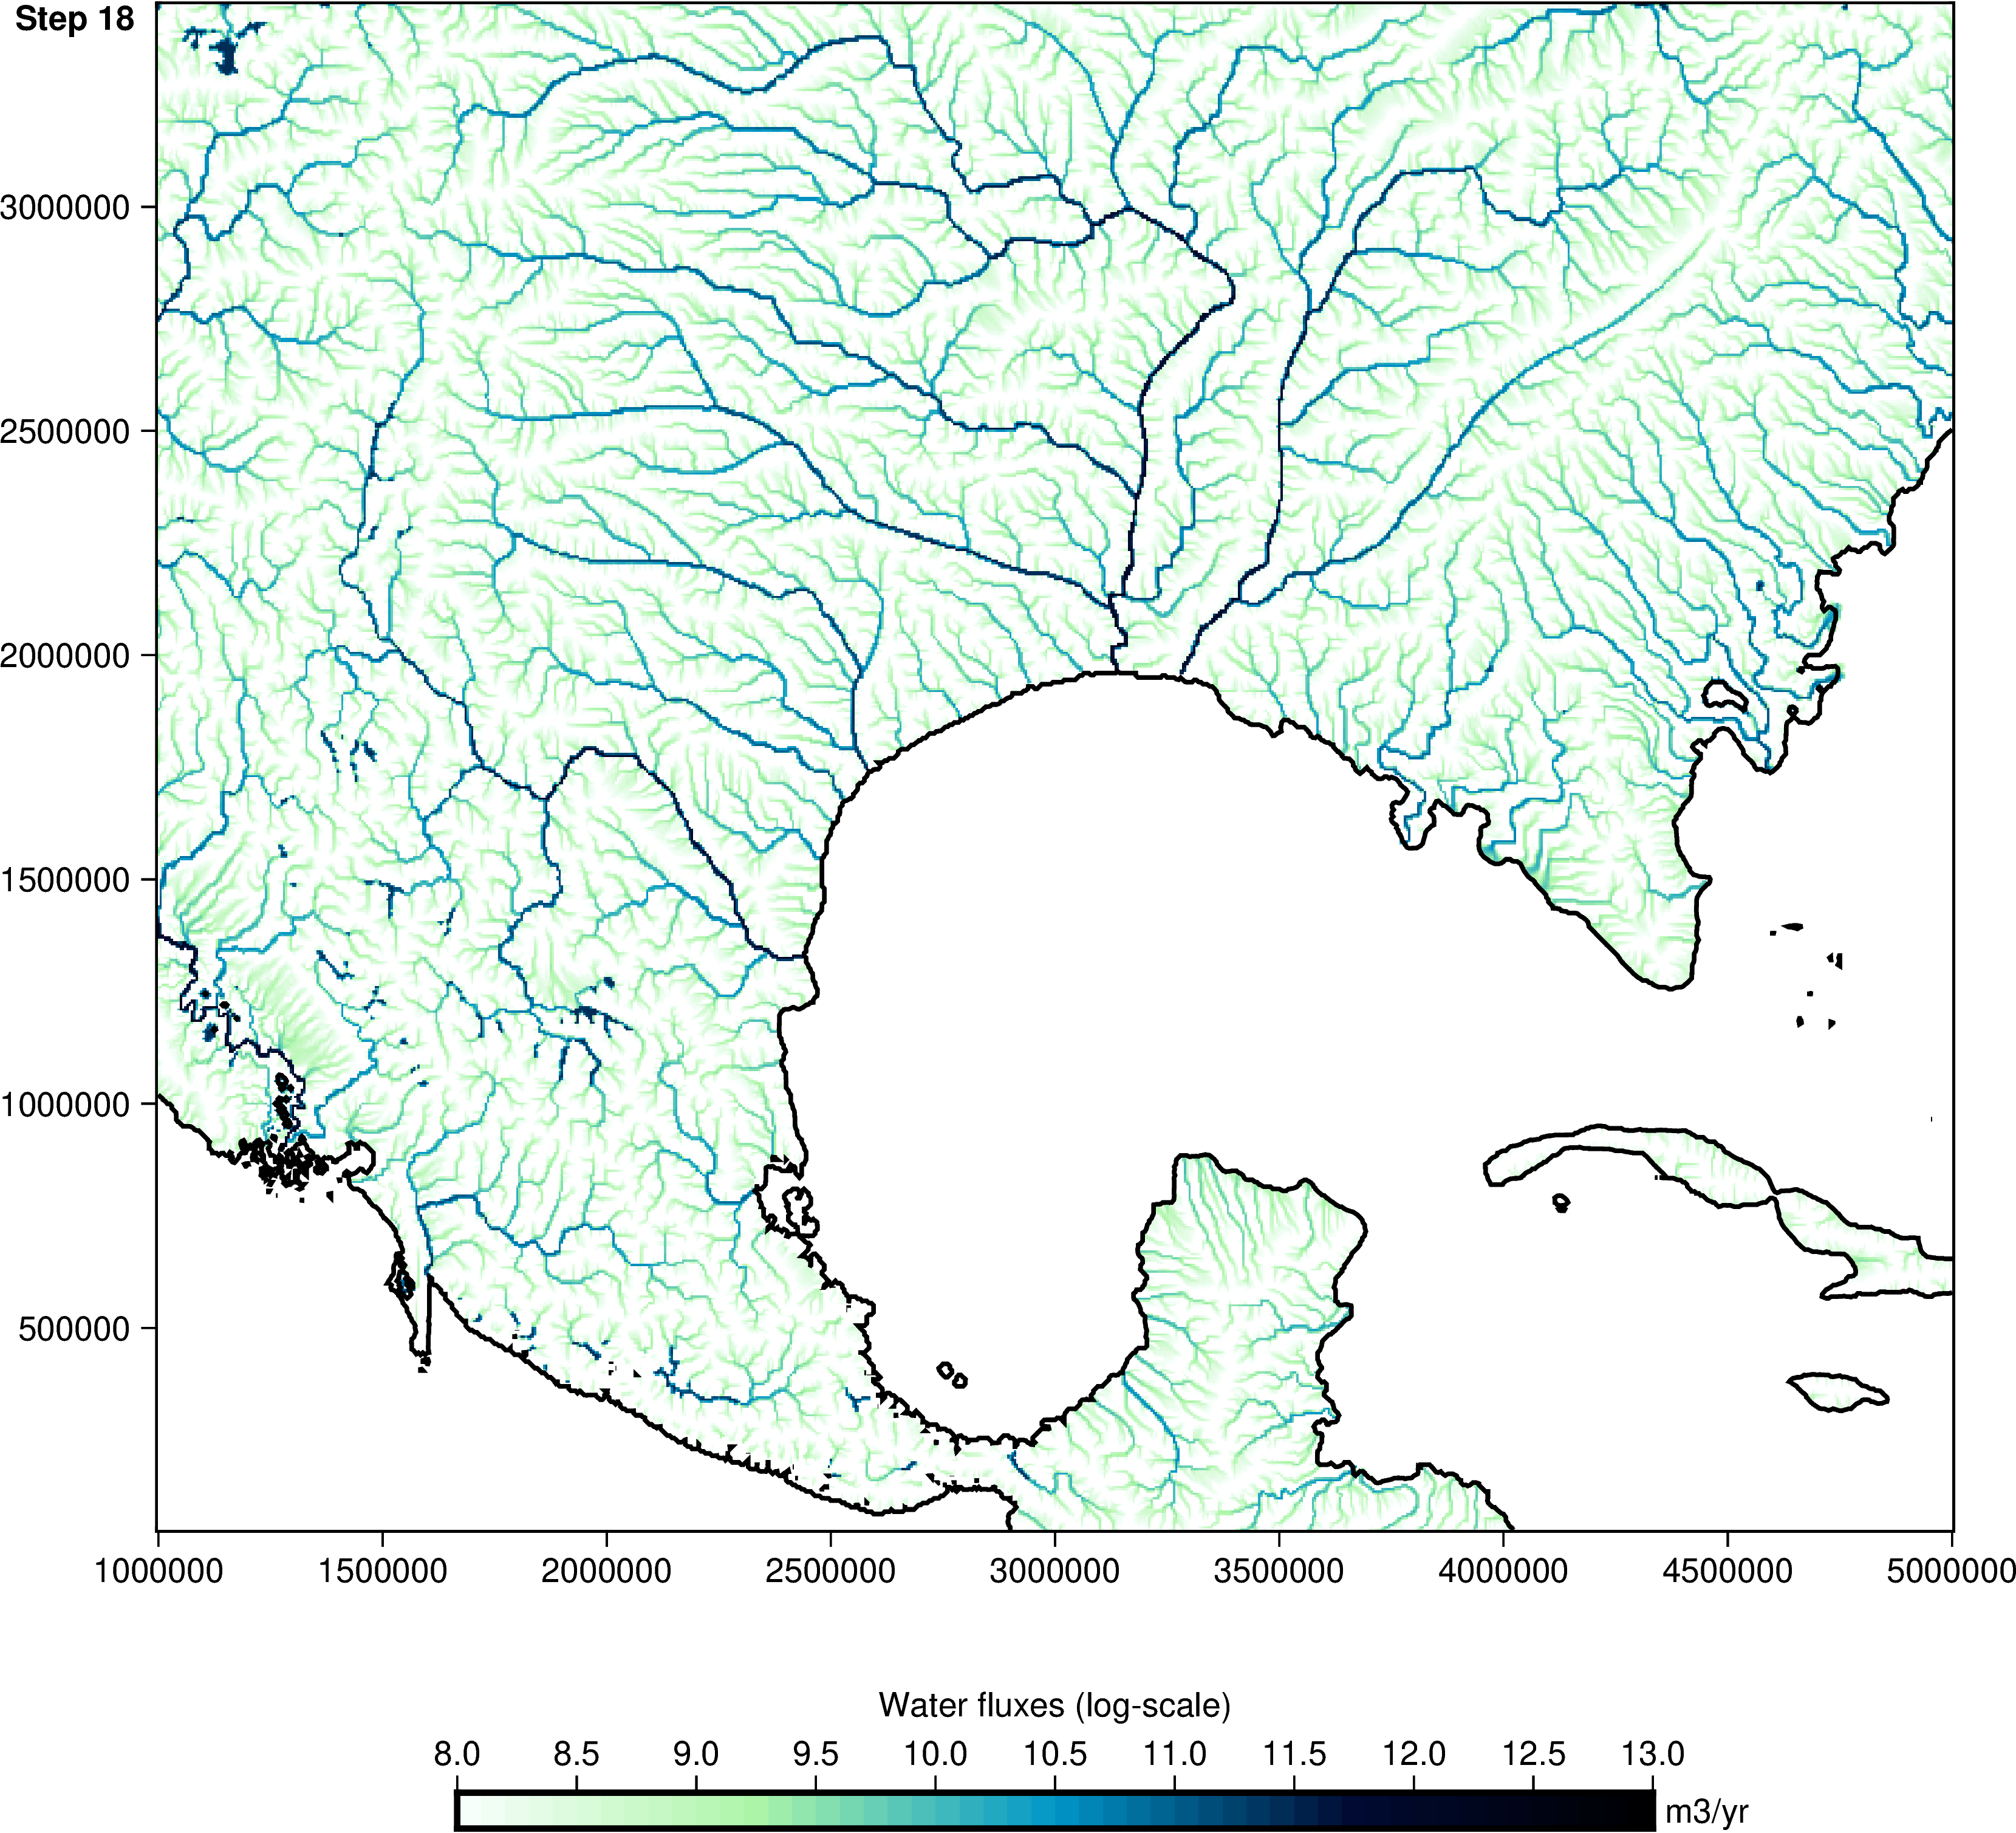

In [55]:
fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black'):
    pygmt.makecpt(
        cmap="ocean",
        series=[8,13,0.1],
        reverse=True,
    )
    
    fig.basemap(
        region=[1.e6,5.e6,5e4,3.45e6],
        frame=['a'],
        projection="X15c/12.75c",
    )
    fig.grdimage(vals, cmap=True, shading=False, frame=False)
    fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
    fig.colorbar(frame=["a0.5", 'x+l"Water fluxes (log-scale)"', "y+lm3/yr"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

    # Customising the font style
    fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
fig.show(dpi=500, width=500)

### Basin


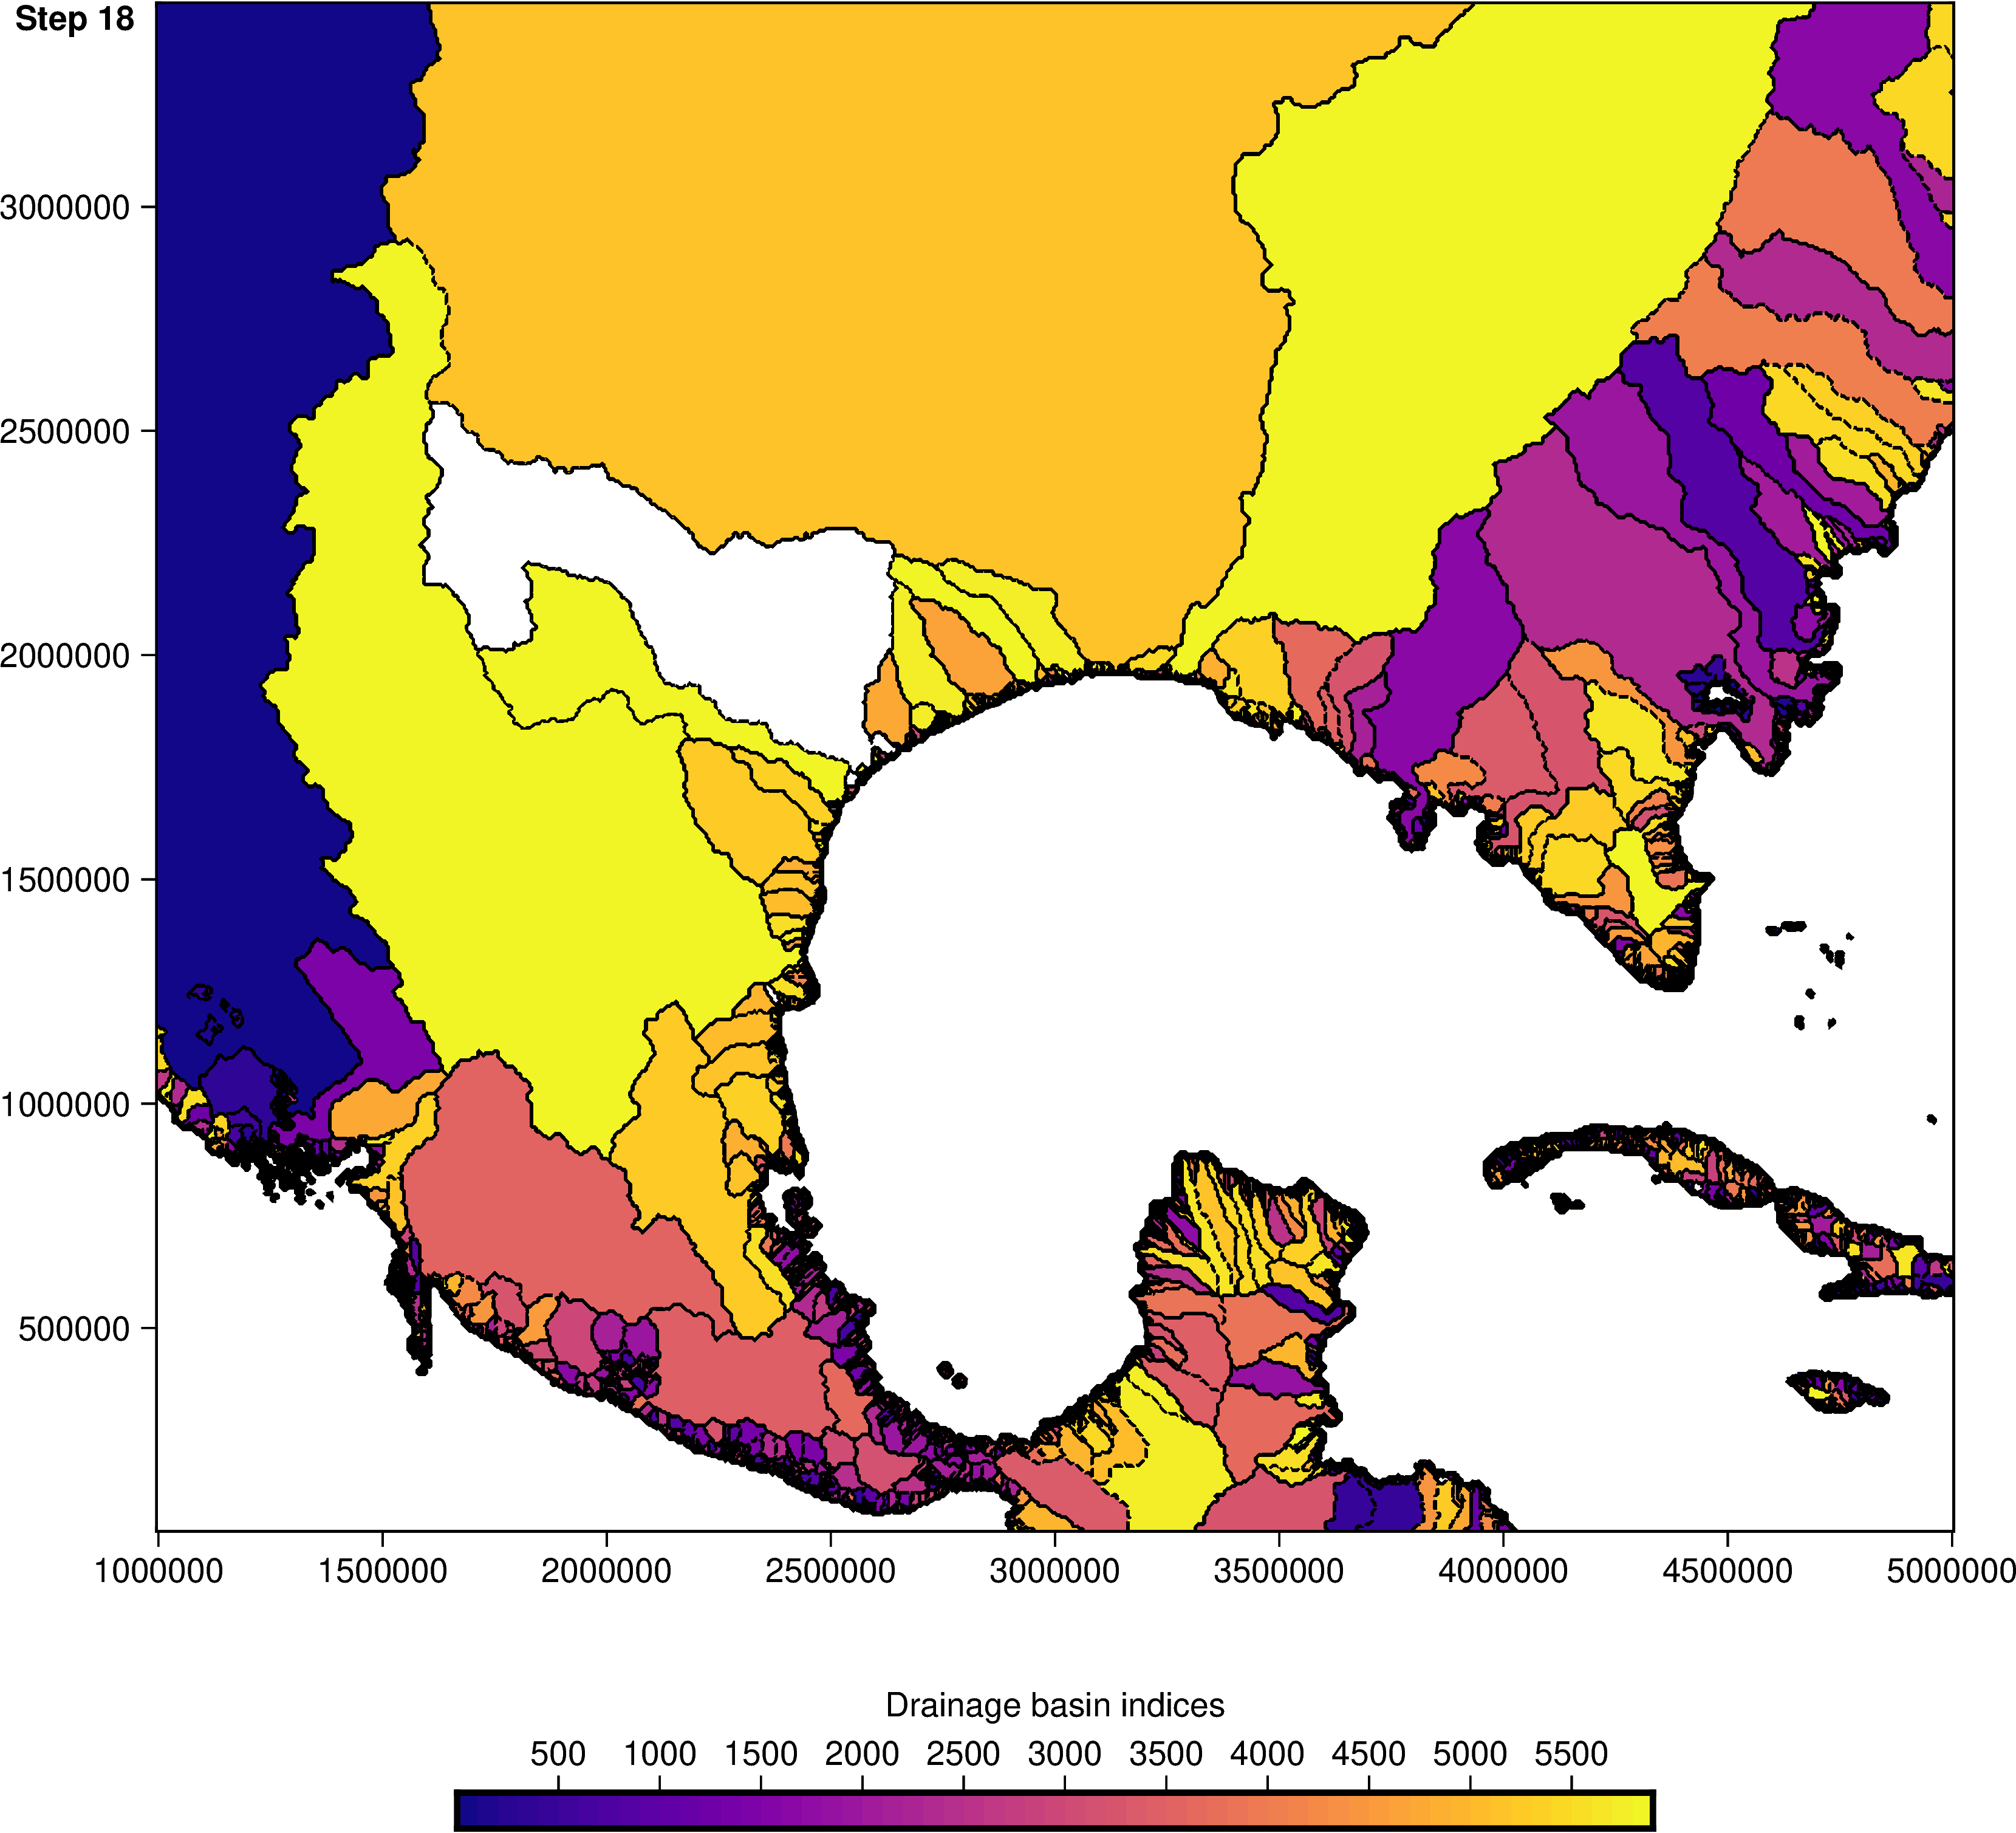

In [58]:
fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black',COLOR_FOREGROUND="white", COLOR_BACKGROUND="white"):
    pygmt.makecpt(
        cmap="plasma", 
        series=[1,6000, 100],
    )
    
    fig.basemap(
        region=[1.e6,5.e6,5e4,3.45e6],
        frame=['a'],
        projection="X15c/12.75c",
    )
    
    fig.grdimage(dataset.basinID, cmap=True, shading=False, frame=False)
    
    # Add basins contour
    fig.grdcontour(
        interval=1,
        grid=dataset.basinID,
        limit=[0, 6000],
        pen = '0.25p,-'
    )
    fig.grdcontour(interval=0.1, grid=dataset.elevation, limit=[-0.0001, 0.0001], pen='1.p')
    
    fig.colorbar(frame=["a500", 'x+l"Drainage basin indices"'], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

    # Customising the font style
    fig.text(text="Step "+str(step), position="TL", font="8p,Helvetica-Bold,black", xshift="-1.2c")
    
fig.show(dpi=500, width=500)